# Testing a base model

Currently i've chosen keras, as it would be quick to try things out + exam comming up (using keras) on 13th of January

In [1]:
# %pip install scikit-learn keras 'tensorflow[and-cuda]' opencv-python python-dotenv pandas sqlalchemy PyMySQL matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

2025-01-06 01:38:04.263938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 01:38:04.275213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736123884.288756   98097 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736123884.292507   98097 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 01:38:04.305719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import keras
import numpy as np
import pandas as pd

In [4]:
from FrameLoader import FrameLoader
from DataRepository import DataRepository
from helpers import plot

In [5]:
repo = DataRepository()
repo.load_relativePaths_of_videos_with_framelabels()
repo.VideoNames.head()
# repo.VideoNames.iloc[0]["name"]

connection established


,folderId,id,name
id,,,
2,3,2,competition/belgium/DD3/bk-handles-dd3-2024-ju...
5,3,5,competition/belgium/DD3/bk-handles-dd3-2024-se...
581,3,581,competition/belgium/DD3/bk-handles-dd3-2024-se...
8,3,8,competition/belgium/DD3/bk-hipeskip-dd3-2024-j...
582,3,582,competition/belgium/DD3/bk-hipeskip-dd3-2024-j...


In [6]:
frameloader = FrameLoader(repo)

In [7]:
f = frameloader.get_frame(8, 66)
f

/media/miked/Elements/Judge/FINISHED-DB-READY/competition/belgium/DD3/bk-hipeskip-dd3-2024-junioren-mixed-j1.MP4


frames


array([[[ 85,  92,  98],
        [ 85,  92,  98],
        [ 85,  92,  98],
        ...,
        [ 46,  56,  60],
        [ 46,  56,  60],
        [ 46,  56,  60]],

       [[ 85,  92,  98],
        [ 85,  92,  98],
        [ 85,  92,  98],
        ...,
        [ 44,  54,  58],
        [ 44,  54,  58],
        [ 44,  54,  58]],

       [[ 85,  92,  98],
        [ 85,  92,  98],
        [ 85,  92,  98],
        ...,
        [ 40,  50,  54],
        [ 40,  50,  54],
        [ 40,  50,  54]],

       ...,

       [[ 55,  50,  62],
        [ 75,  70,  82],
        [ 73,  68,  80],
        ...,
        [117, 122, 122],
        [114, 119, 119],
        [116, 121, 121]],

       [[ 54,  49,  61],
        [ 76,  71,  83],
        [ 74,  69,  81],
        ...,
        [131, 127, 115],
        [127, 123, 111],
        [124, 120, 108]],

       [[ 48,  43,  55],
        [ 75,  70,  82],
        [ 75,  70,  82],
        ...,
        [131, 127, 115],
        [127, 123, 111],
        [123, 119, 107]]

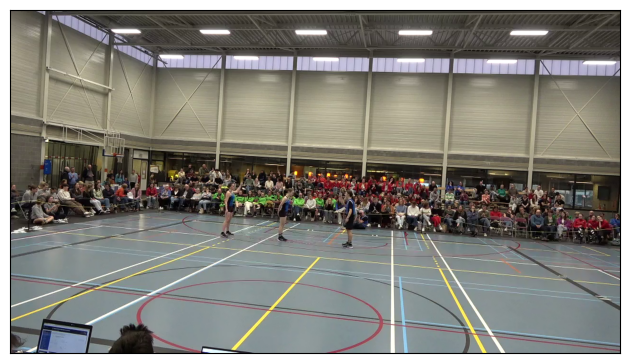

In [8]:
plot([f])

In [9]:
repo.VideoNames.head()

,folderId,id,name
id,,,
2,3,2,competition/belgium/DD3/bk-handles-dd3-2024-ju...
5,3,5,competition/belgium/DD3/bk-handles-dd3-2024-se...
581,3,581,competition/belgium/DD3/bk-handles-dd3-2024-se...
8,3,8,competition/belgium/DD3/bk-hipeskip-dd3-2024-j...
582,3,582,competition/belgium/DD3/bk-hipeskip-dd3-2024-j...


In [10]:
repo.VideoNames.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 2 to 142
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   folderId  57 non-null     int64 
 1   id        57 non-null     int64 
 2   name      57 non-null     object
dtypes: int64(2), object(1)
memory usage: 3.8+ KB


In [11]:
repo.VideoNames.loc[581]["name"]

'competition/belgium/DD3/bk-handles-dd3-2024-senioren-mixed-z1.mp4'

In [15]:
class DataGeneratorFrames(keras.utils.Sequence):
    def __init__(self,
                 frameloader,
                 train_test_val: str, # train, test, val
                 dim: tuple, # e.g. (128,128)
                 batch_size=32, # Default batch size
                 **kwargs):
        super().__init__(**kwargs)
        assert isinstance(dim, tuple)
        assert len(dim) == 2
        assert isinstance(train_test_val, str)
        assert train_test_val in ['train', 'test', 'val']
        self.dim = dim
        self.train_test_val = train_test_val
        self.batch_size = batch_size
        self.frameloader = frameloader
        self.repo = DataRepository()
        self.Frames = self.repo.get_framelabels(train_test_val)

        print('DataGeneratorSkillBorders init done')
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        print("len")
        return len(self.Frames) // self.batch_size

    def __getitem__(self, batch_nr):
        "batch_nr starts from 0"
        print("getitem", batch_nr)
        return batch_nr, "y"


    def on_epoch_end(self):
        print('on_epoch_end_called')
        self.Frames = self.Frames.sample(frac=1.)


In [16]:
train_gen = DataGeneratorFrames(
    frameloader=frameloader,
    train_test_val="train",
    dim=(64,64),
    batch_size=32
)

connection established
DataGeneratorSkillBorders init done
on_epoch_end_called


In [18]:
train_gen.__getitem__(0)

getitem 0


(0, 'y')

In [14]:
class DataGeneratorRectangles(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, train=True, dim=(128, 128), n_channels=3, batch_size=32,
                 n_classes=3, shuffle=True, axis=0, **kwargs):
        'Initialization'
        super().__init__(**kwargs)
        self.dim = dim
        self.train = train
        self.batch_size = batch_size
        self.n_channels = n_channels  # RGB or gray
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.len = None
        self.axis=axis

        self.repo = DataRepository()

        print('DataGeneratorSkillBorders init done')
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.batch_order)

    def __getitem__(self, batch_nr):
        'Generate one batch of data'
        # Generate batch df view
        print(f" __getitem__({batch_nr})")
        video_id = self.batch_order.iloc[batch_nr]['videoID']
        video_batch_nr = self.batch_order.iloc[batch_nr]['batch_nr_video']

        # print(f"get_rects: {video_id}", video_batch_nr, self.batch_size)
        df_labels = self.repo.get_rectangles_from_batch(videoID=video_id, batch_nr=video_batch_nr, batch_size=self.batch_size)
        if (len(df_labels) < self.batch_size):
            pass
            # print('df_labels: ', df_labels)
            # df_labels = self.fill_time_length_dimension(df_labels)

        y = np.array(df_labels[['rect_center_x', 'rect_center_y', 'rect_size']])

        # y = np.expand_dims(y, axis=0)
        # y = np.expand_dims(y, axis=-1)
         
        min_frame = df_labels.iloc[0]['frameNr']
        max_frame = df_labels.iloc[-1]['frameNr']
        path = '../' + self.repo.get_path(video_id)
        X = get_frames(path, min_frame, max_frame, dim=self.dim)

        # X = np.expand_dims(X, axis=0)  # Add batch dimension
        
        return X, y

    def fill_time_length_dimension(self, df_labels):
        print('fill_time_length_dimension_called')
        min_frame = df_labels.iloc[-1]['frameNr'] + 1
        max_frame_exlcuded = df_labels.iloc[0]['frameNr'] + self.batch_size
        arr = np.arange(min_frame, max_frame_exlcuded)
        df_fill = pd.DataFrame({
            'frameNr': [7777 for i in arr],
            'label': [0 for i in arr]
        })
        return pd.concat([df_labels, df_fill])

    def on_epoch_end(self):
        print('on_epoch_end_called')
        'Updates indexes after each epoch'
        # shuffle, insert indexes remain, position in df changes
        self.batch_order = self.repo.get_batch_order_frames(self.batch_size, self.train)
        # print(self.batch_order)